In [101]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from wordcloud import WordCloud
from IPython.display import display
from plotly.subplots import make_subplots
import seaborn as sns
import textwrap
import os

# BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import openai
from bertopic.representation import OpenAI
from sklearn.metrics.pairwise import cosine_similarity

## **TABLE OF CONTENTS**:
- [DATASET](#dataset)
- [HOW TO USE](#how_to_use)
- [SEARCH DATASET](#search-dataset)
- [PARAMETERS](#parameters)
- [LOAD DATA](#load-data)
- [EXECUTE BERT](#execute-bert)
- [ANALYZE CLUSTERS](#analyze-clusters)
  - [TOPIC BARCHART](#topic_barchart)
  - [TOPIC HIERARCHY](#topic_hierarchy)
  - [TOPIC DISTANCE MAP](#topic_distance)
- [MERGE CLUSTERS INTO DATASET](#merge_clusters)
- [TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER](#query_assign)
  - [ASSIGNED TOPICS WORDCLOUD](#topic_worldcloud)
- [VIZUALIZATIONS FOR ONE SPECIFIC TOPIC](#visual_one)
  - [PROJECTS IN TOPIC](#projects_topic)
  - [RELATED TOPICS](#topic_related)
- [VIZUALIZATIONS FOR MULTIPLE TOPICS](#visual_multiple)
  - [PROJECT COUNT OVER TIME](#project_count)
  - [FUNDING SCHEMES](#funding)
  - [DEPARTMENTS](#departments)
  - [SUB-DEPARTMENTS](#sub_departments)
  - [FUNDING SCHEMES IN DEPTH](#funding_depth)
- [VISUALIZATIONS WHOLE DATASET](#funding_whole)
  - [FUNDING](#funding_whole)
- [DEEP DIVE INTO TOPIC](#deep_dive)
- [SOURCES](#sources)

## **HOW TO USE** <a class="anchor" id="how_to_use"></a>
1. Select dataset
2. Input a query 
3. Set parametes
4. Run all
5. Use table of contents to get desired info <br>

Note: some visualizations have extra parameters that can be set, for convenience those are at the specific visualizations.

## **DATASET** <a class="anchor" id="dataset"></a>

In [102]:
DATASET = "../data/rvo_df_eng.pkl" # dataset name / location
EXPORT_TOPICS = False # set to true if you want to export all topics
DF_TOPICS = "df_topics_info.csv" # set name for exported topics data (must be .csv)
EXPORT_TOPICS_MERGED = False # set to true if you want to export dataset with topics
DF_TOPICS_MERGED = "df_projects_merged_topics.csv" # set name for exported dataset with topics (must be .csv)

## **SEARCH DATASET** <a class="anchor" id="search-dataset"></a>

In [103]:
# input your project query here, e.g. roman empire alexander the great greece
QUERY = ['sustainability industry innovation process technology innovation raw materials circularity consumption goods']
# QUERY = ['universiteit van amsterdam']
# QUERY = ["ai artifical intelligence"]
# QUERY = ["circular cycle raw materials resources materials industrial materials recycling high-quality reuse reuse supply security waste waste chains plastic plastics polymers polymers pet pvc cement concrete concrete glass glass e-waste steel steel biomaterial bioplastic geopolitics manufacturing industry industry industrial"]
# QUERY = ["roman empire alexander the great greece macedonia xerxes"]

## **PARAMETERS** <a class="anchor" id="parameters"></a>

In [104]:
# the model
LOAD_EMBEDDINGS = True  # set to True if embeddings are pre-saved
LOAD_MODEL = True  # set to True if a model is pre-saved
USE_OPENAI_REPERESENTATIONS = True  # set to True to use ChatGPT for generating topic labels

# assigning topics
TOPIC_COUNT = 8  # number of topics to identify; higher values will reduce accuracy
MIN_PROJECTS_CLUSTER = 0 # set higher to filter out topics with few projects

# visualizations
SAVE_PLOTS = False  # set to True to save visualizations as PDF files
START_YEAR = 2015  # start year for generating visualizations
END_YEAR = 2023  # end year for generating visualizations

## **LOAD DATA** <a class="anchor" id="load-data"></a>

In [105]:
df_projects = pd.read_pickle(DATASET)

In [106]:
pd.set_option('display.max_columns', None)

print(df_projects.shape)
display(df_projects.head(1))


(707, 14)


,Subsidie categorie,TKI/Thema,Innovatiethema('s),Subsidieregeling,Projectnummer,Looptijd,Subsidiebedrag,Penvoerder,Projectconsortium,Projecttitel,Publieke samenvatting,Website link,text,language
0,Versnelde klimaatinvesteringen industrie (VEKI),Directe effecten aan de schoorsteen (scope 1),Energie-efficiency,VEKI-23-01-01-Klimaatinvest. Indus.,VEKI523010,01-07-2023 - 31-12-2025,1549579.0,Kingspan Insulation B.V.,Kingspan Insulation B.V.,electricaldriven drying ovens,aanleiding currently the kingspans kooltherm i...,https://projecten.topsectorenergie.nl/projecte...,electricaldriven drying ovens aanleiding curre...,en


In [107]:
COLUMN_FUNDING_SCHEME = 'Subsidie categorie'
COLUMN_PROJECT_ID = 'Projectnummer'

## **EXECUTE BERT** <a class="anchor" id="execute-bert"></a>

In [108]:
# OpenAI prompt
prompt = """
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short but highly descriptive topic label of at most 5 words. Make sure it is in the following format:
topic: <topic label>
"""

client = openai.OpenAI()
openai_model = OpenAI(client, model="gpt-3.5-turbo-0125", exponential_backoff=True, chat=True, prompt=prompt)

representation_model = {
    "OpenAI": openai_model
}
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
vectorizer_model = CountVectorizer(stop_words="english")

In [109]:
docs = list(df_projects.text.values) # create stacked list of abstracts

if LOAD_EMBEDDINGS:
    # load embeddings
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = np.load('embeddings/rvo/embeddings.npy')
else:
    # pre-embed abstracts
    sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
    embeddings = sentence_model.encode(docs, show_progress_bar=True)
    
    # Ensure the directory exists
    save_dir = 'embeddings/rvo/'
    os.makedirs(save_dir, exist_ok=True)
    
    # save embeddings
    np.save(os.path.join(save_dir, 'embeddings.npy'), embeddings)

In [110]:
if LOAD_MODEL:
    # load the BERTopic model
    topic_model = BERTopic.load("models/rvo/BERTopic")

    # use the transform method to obtain topics and probabilities for the new documents
    topics, probs = topic_model.transform(docs, embeddings)
else:
    topic_model = BERTopic(verbose=True, 
                        calculate_probabilities=True,
                        top_n_words=8,
                        n_gram_range=(1, 2),
                        min_topic_size=8,
                        vectorizer_model=vectorizer_model,
                        representation_model=representation_model,
                        embedding_model=sentence_model)

    topics, probs = topic_model.fit_transform(docs, embeddings)
    
    # Ensure the directory exists
    save_dir = 'models/rvo/'
    os.makedirs(save_dir, exist_ok=True)

    # save the model
    embedding_model = "sentence-transformers/all-MiniLM-L6-v2"
    topic_model.save(os.path.join(save_dir, "BERTopic"), serialization="safetensors", save_embedding_model=embedding_model)

2024-06-14 11:42:54,952 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.


In [111]:
if USE_OPENAI_REPERESENTATIONS is True:
    # add chatgpt labels to the model
    chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
    chatgpt_topic_labels[-1] = "Outlier Topic"
    topic_model.set_topic_labels(chatgpt_topic_labels)

topic_model.get_topic_info().head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,163,-1_process_project_production_energy,Outlier Topic,"[process, project, production, energy, new, in...",[Sustainable Energy Efficient Production],NaN
1,0,94,0_plastic_recycling_waste_plastics,Plastic Waste Recycling Solutions,"[plastic, recycling, waste, plastics, project,...",[Plastic Waste Recycling Solutions],NaN


## **ANALYZE CLUSTERS** <a class="anchor" id="analyze-clusters"></a>

In [112]:
# show most prominent topics
df_topic_info = topic_model.get_topic_info()
df_topic_info.head(2)

,Topic,Count,Name,CustomName,Representation,OpenAI,Representative_Docs
0,-1,163,-1_process_project_production_energy,Outlier Topic,"[process, project, production, energy, new, in...",[Sustainable Energy Efficient Production],NaN
1,0,94,0_plastic_recycling_waste_plastics,Plastic Waste Recycling Solutions,"[plastic, recycling, waste, plastics, project,...",[Plastic Waste Recycling Solutions],NaN


In [113]:
if EXPORT_TOPICS is True:
    df_topic_info.to_csv(DF_TOPICS, index=False)

**Topic -1 are outliers**

#### **TOPIC BARCHART** <a class="anchor" id="topic_barchart"></a>

In [114]:
topic_model.visualize_barchart(top_n_topics=8, n_words=10, custom_labels=True, width=400)

#### **TOPIC HIERARCHY** <a class="anchor" id="topic_hierarchy"></a>

In [115]:
topic_model.visualize_hierarchy(custom_labels=True)

#### **TOPIC DISTANCE MAP** <a class="anchor" id="topic_distance"></a>

In [116]:
topic_model.visualize_topics(custom_labels=True)

## **MERGE CLUSTERS INTO DATASET** <a class="anchor" id="merge_clusters"></a>

In [117]:
df_projects = pd.read_pickle(DATASET)
df_projects = df_projects.copy()

In [118]:
df_projects['Topic'] = topics
df_projects.head(1)

,Subsidie categorie,TKI/Thema,Innovatiethema('s),Subsidieregeling,Projectnummer,Looptijd,Subsidiebedrag,Penvoerder,Projectconsortium,Projecttitel,Publieke samenvatting,Website link,text,language,Topic
0,Versnelde klimaatinvesteringen industrie (VEKI),Directe effecten aan de schoorsteen (scope 1),Energie-efficiency,VEKI-23-01-01-Klimaatinvest. Indus.,VEKI523010,01-07-2023 - 31-12-2025,1549579.0,Kingspan Insulation B.V.,Kingspan Insulation B.V.,electricaldriven drying ovens,aanleiding currently the kingspans kooltherm i...,https://projecten.topsectorenergie.nl/projecte...,electricaldriven drying ovens aanleiding curre...,en,6


In [119]:
df_projects['Topic'] = df_projects['Topic'].astype(int)

df_projects = pd.merge(df_projects, df_topic_info[['Topic', 'Representation', 'CustomName']], left_on='Topic', right_on='Topic', how='left')

In [120]:
df_projects.head(1)

,Subsidie categorie,TKI/Thema,Innovatiethema('s),Subsidieregeling,Projectnummer,Looptijd,Subsidiebedrag,Penvoerder,Projectconsortium,Projecttitel,Publieke samenvatting,Website link,text,language,Topic,Representation,CustomName
0,Versnelde klimaatinvesteringen industrie (VEKI),Directe effecten aan de schoorsteen (scope 1),Energie-efficiency,VEKI-23-01-01-Klimaatinvest. Indus.,VEKI523010,01-07-2023 - 31-12-2025,1549579.0,Kingspan Insulation B.V.,Kingspan Insulation B.V.,electricaldriven drying ovens,aanleiding currently the kingspans kooltherm i...,https://projecten.topsectorenergie.nl/projecte...,electricaldriven drying ovens aanleiding curre...,en,6,"[steel, tata, iron, carbon, production, pilot,...",Steel Production Pilot Project


In [121]:
if EXPORT_TOPICS_MERGED is True:
    df_projects.to_csv(DF_TOPICS_MERGED, index=False)

## **TRANSFORM QUERY AND ASSIGN CLOSEST CLUSTER** <a class="anchor" id="query_assign"></a>

##### Note: these are the topics related to your query.

In [122]:
print(f"Input query: '{QUERY[0]}'\n")

similar_topics, similarity = topic_model.find_topics(QUERY[0], top_n=TOPIC_COUNT)
print(f"Topics found (numbers): {similar_topics}\n")
TOPICS = [topic for topic in similar_topics if len(df_projects[df_projects['Topic'] == topic]) >= MIN_PROJECTS_CLUSTER]

print("Topics, ranked top to bottom, match with query:\n")
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            print(f"({i}): {topic_projects['CustomName'].iloc[0]}")

Input query: 'sustainability industry innovation process technology innovation raw materials circularity consumption goods'

Topics found (numbers): [0, 15, 12, 10, 8, -1, 11, 6]

Topics, ranked top to bottom, match with query:

(0): Plastic Waste Recycling Solutions
(15): Innovation Roadmap for SME Efficiency
(12): Tire Recycling Innovations
(10): Circular Foam Materials Development
(8): Concrete Recycling Innovations
(11): Sustainable Bioaromatics Coatings
(6): Steel Production Pilot Project


#### **ASSIGNED TOPICS WORDCLOUD** <a class="anchor" id="topic_worldcloud"></a>

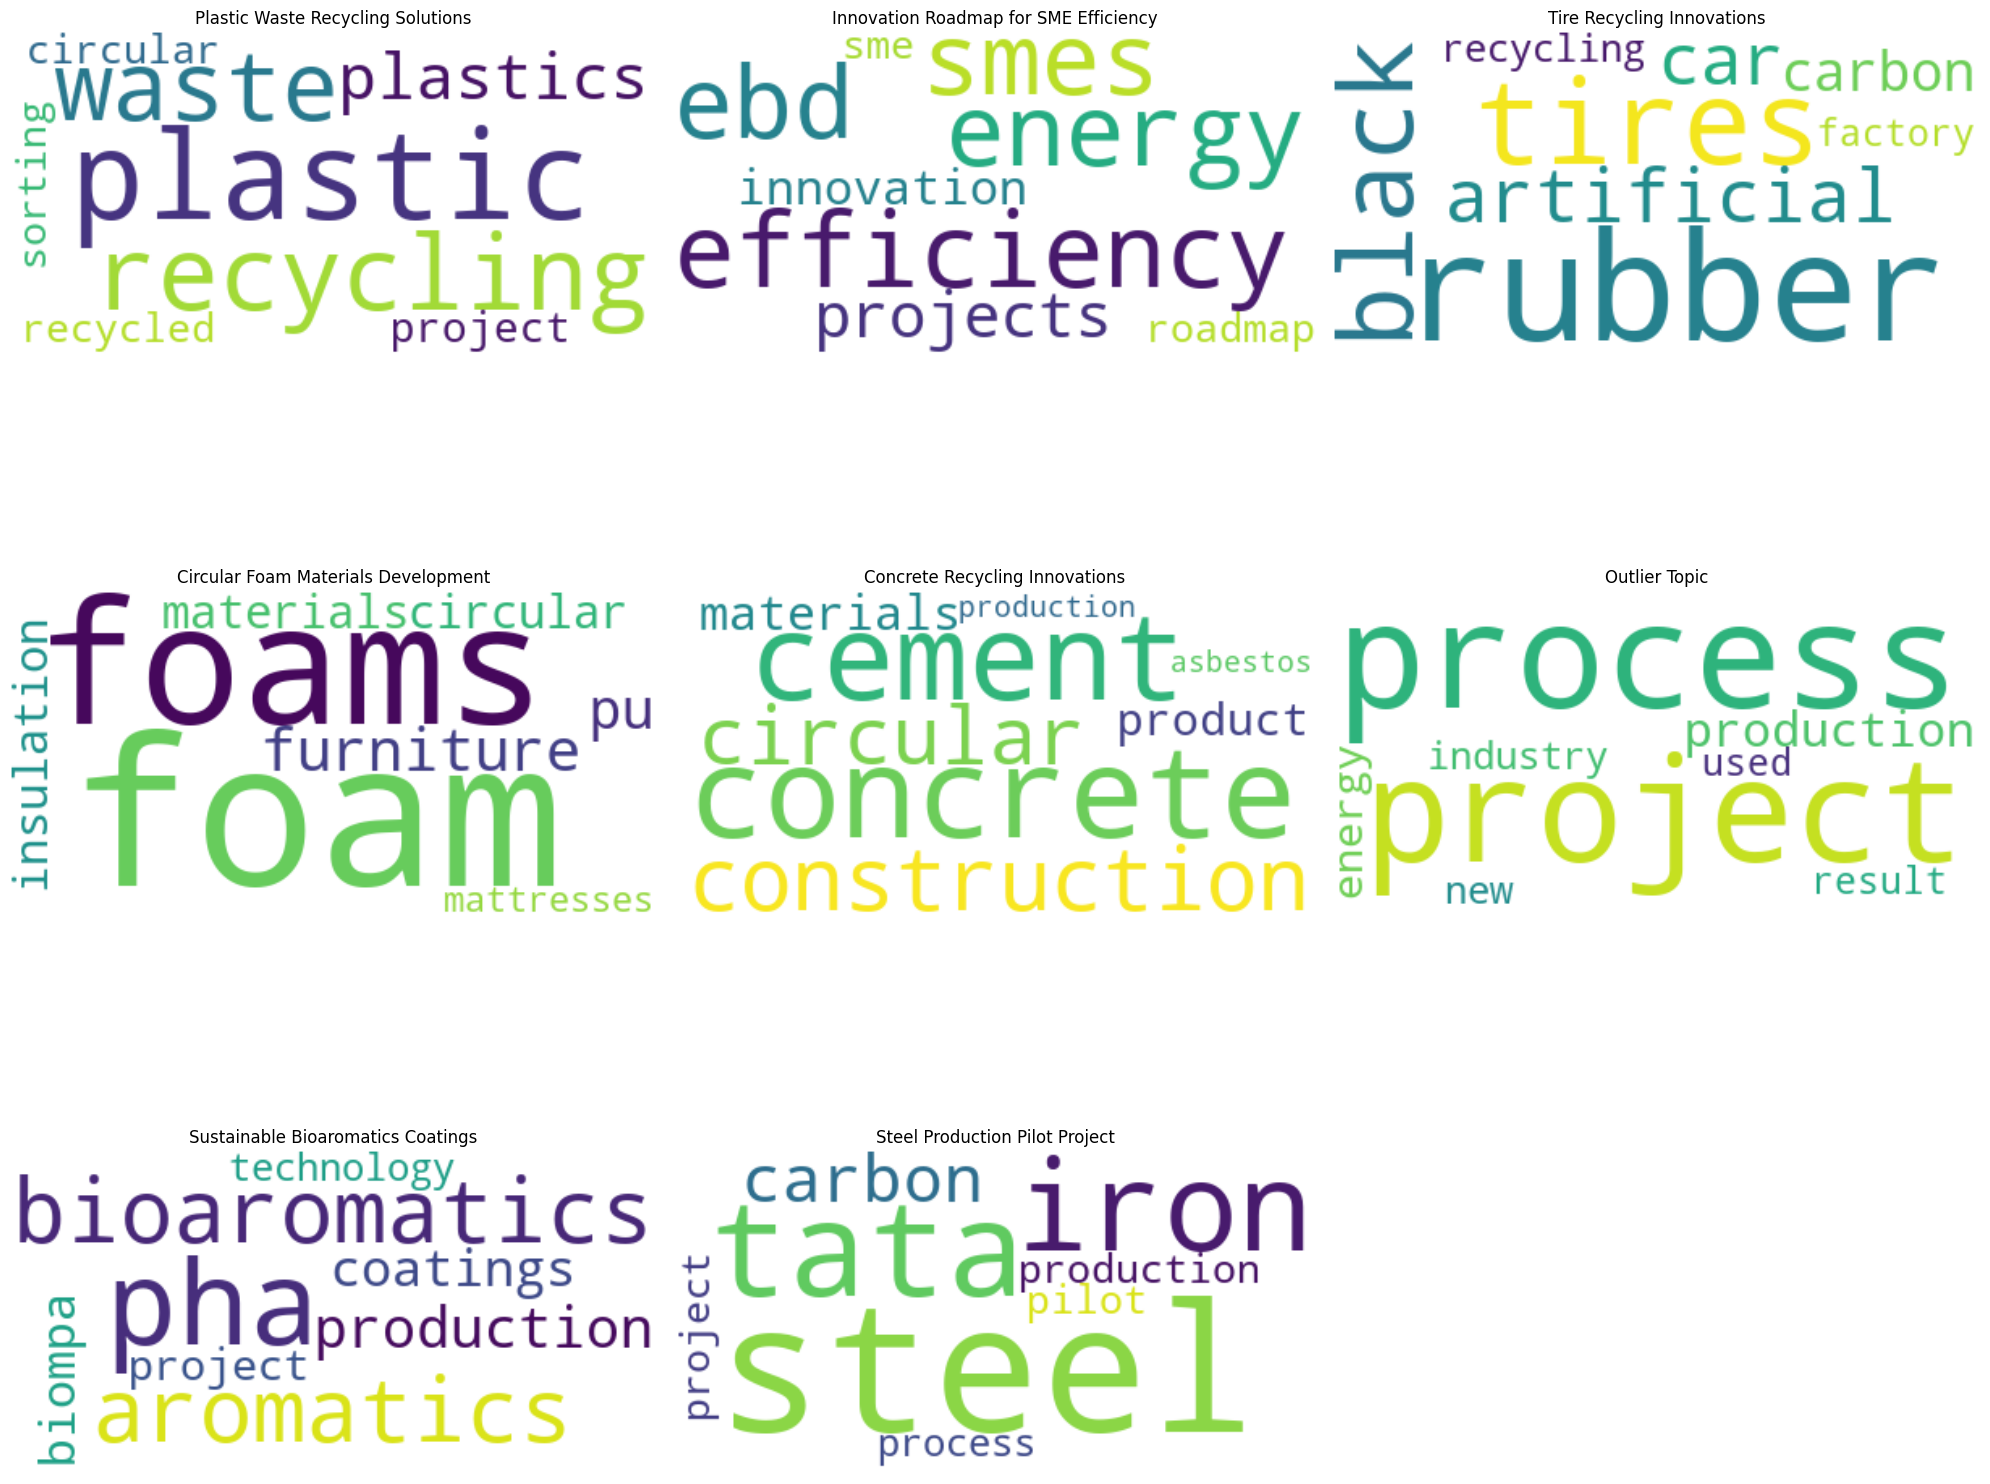

In [123]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    return wc.generate_from_frequencies(text)

# generate and plot each word cloud
cols = 3  # maximum three plots per row
rows = (len(TOPICS) + cols - 1) // cols  # calculate the number of rows needed
plt.figure(figsize=(20, 6 * rows))  # adjust figure size as needed

for index, topic in enumerate(TOPICS):
    plt.subplot(rows, cols, index + 1)  # create a subplot for each topic
    wc = create_wordcloud(topic_model, topic=topic)
    
    # retrieve the custom name for the topic
    topic_projects = df_projects[df_projects['Topic'] == topic]
    if not topic_projects.empty:
        title = topic_projects['CustomName'].iloc[0]
    else:
        title = f"Topic {topic}"
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout()
plt.show()

## **VIZUALIZATIONS FOR ONE SPECIFIC TOPIC** <a class="anchor" id="visual_one"></a>

##### How to use: Choose a single topic you want to visualize, pick one number from the topics that where assigned to your query. By default this will be the topic that best matched your query. The topics found are listed here again below:

In [124]:
print("Topics, ranked top to bottom, match with query:\n")
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            print(f"({i}): {topic_projects['CustomName'].iloc[0]}")

Topics, ranked top to bottom, match with query:

(0): Plastic Waste Recycling Solutions
(15): Innovation Roadmap for SME Efficiency
(12): Tire Recycling Innovations
(10): Circular Foam Materials Development
(8): Concrete Recycling Innovations
(11): Sustainable Bioaromatics Coatings
(6): Steel Production Pilot Project


In [125]:
SELECTED_TOPIC_ID = TOPICS[0] # choose topic for visualizations, default is best match with query (the top one). Example input: 35

In [126]:
TOPIC_INDEX = SELECTED_TOPIC_ID + 1
SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print(f'Selected topic is: ({SELECTED_TOPIC_ID}): {SELECTED_TOPIC_NAME}')

Selected topic is: (0): Plastic Waste Recycling Solutions


#### **PROJECTS IN TOPIC** <a class="anchor" id="projects_topic"></a>

In [127]:
THRESHOLD_DOC_PROB_TABLE = 0.1  # Adjust the threshold based on your needs

This table shows the likelihood that projects belong to Topic (1) Plastic Waste Recycling Solutions 


,document,probability
0,geleen plasticplastic recycling aanleiding pla...,0.79
1,downstream isolation of highvalue components a...,0.79
2,sustainable softening line for nonferrous meta...,0.76
3,converting wastewater into composites reason t...,0.76
4,altruistic innovative co reduction of atmosphe...,0.76
...,...,...
702,feasibility study on specialwhite led lighting...,0.30
703,innovation advisory services brief description...,0.23
704,bbi sme short description sme affiliation with...,0.23
705,exploitation innovation clusters objective sma...,0.22


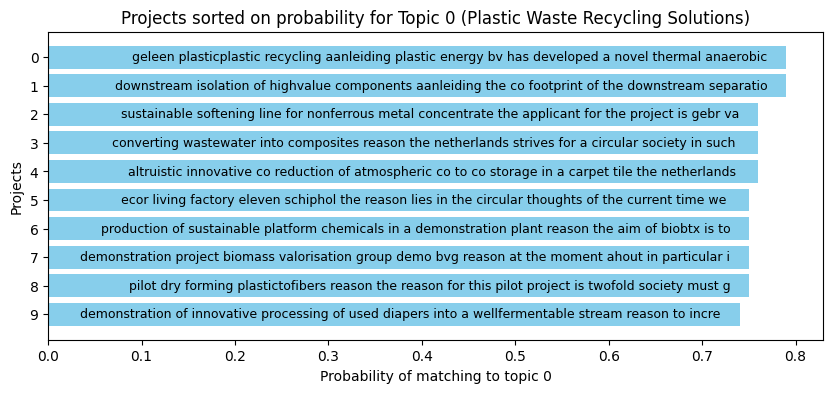

In [128]:
topic_name = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
print(f'This table shows the likelihood that projects belong to Topic ({TOPIC_INDEX}) {SELECTED_TOPIC_NAME} ')

# Extract the probabilities for the specific topic
specific_topic_probs = probs[:, SELECTED_TOPIC_ID]

# Find the indices of documents with a probability above the threshold for the specific topic
doc_indices = np.where(specific_topic_probs >= THRESHOLD_DOC_PROB_TABLE)[0]

# Retrieve the documents with the specific topic
docs_with_specific_topic = [docs[i] for i in doc_indices]

# Create a DataFrame with the documents and their probabilities for the specific topic
df_specific_topic = pd.DataFrame({
    'document': docs_with_specific_topic,
    'probability': specific_topic_probs[doc_indices]
})

# Sort the DataFrame in descending order by probability
df_specific_topic = df_specific_topic.sort_values(by='probability', ascending=False).reset_index(drop=True)

df_specific_topic['probability'] = df_specific_topic['probability'].round(2)

display(df_specific_topic)


df_specific_topic_top_n = df_specific_topic.head(10)
# Truncate the 'document' column to 100 characters
df_specific_topic_top_n['document'] = df_specific_topic_top_n['document'].str.slice(0, 100)



# Plotting
plt.figure(figsize=(10, 4))  # Change height to a smaller value
bars = plt.barh(df_specific_topic_top_n.index, df_specific_topic_top_n['probability'], color='skyblue')
plt.xlabel(f'Probability of matching to topic {SELECTED_TOPIC_ID}')
plt.ylabel('Projects')
plt.title(f'Projects sorted on probability for Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})')


# Setting yticks to ensure all labels are shown
plt.yticks(ticks=range(len(df_specific_topic_top_n)), labels=df_specific_topic_top_n.index)

# Adding text inside the bars
for bar, doc_text in zip(bars, df_specific_topic_top_n['document']):
    plt.text(
        bar.get_width() - 0.02,  # Adjust the position of the text within the bar
        bar.get_y() + bar.get_height() / 2,
        doc_text,
        ha='right',  # Align text to the right
        va='center',
        fontsize=9,
        color='black',
        wrap=True
    )

plt.gca().invert_yaxis()  # Invert y-axis to have the highest probability at the top
plt.show()

##### Use this cell to read the full summary text of a project based on the figures above

In [129]:
# SELECTED_PROJECT_ID refers to the IDs shown in the figure above which is based relative to your selected topic (this is not the original project ID)
SELECTED_PROJECT_ID = 0

In [130]:
document_text = df_specific_topic['document'][SELECTED_PROJECT_ID]

document_text = textwrap.fill(document_text, width=130)
print(document_text)

geleen plasticplastic recycling aanleiding plastic energy bv has developed a novel thermal anaerobic conversion tac technology to
recycle end of life eol plastic waste into tacoil a hydrocarbon that can be used to produce virgin plastic products plastic energy
wants to demonstrate this technology in a new processing plant to be developed and constructed in geleen the netherlands plastic
energy has experience with two other plants currently in operation using similar technology but on a smaller scale this project
comprises of a demonstration project for a fourtime scaleup of the current technology as operated in two smaller spanish plants
doelstelling the goal of plastic energy and renewi is to achieve plastic recycling by processing end of life plastic waste into
tacoil a hydrocarbon which can be used to produce virgin plastic products plasticplastic recycling this would ensure a transition
from single use plastics to multi use plastics without the need for new fossilbased materials ci

#### **RELATED TOPICS** <a class="anchor" id="topic_related"></a>

In [131]:
# Extract the topic embeddings
topic_embeddings = topic_model.topic_embeddings_

# Get the embedding of the specific topic
specific_topic_embedding = topic_embeddings[TOPIC_INDEX].reshape(1, -1)

# Compute the cosine similarity between the specific topic and all other topics
similarities = cosine_similarity(specific_topic_embedding, topic_embeddings).flatten()

# Convert similarities to distances (1 - similarity)
distances = 1 - similarities

# Round distances to 2 decimal places
distances = np.round(distances, 2)

# Sort the distances and get the corresponding topic indices
sorted_indices = np.argsort(distances)

# Show results
topic_info = topic_model.get_topic_info().loc[sorted_indices].iloc[:, :5]

# Rename the 'Count' column to 'document_count'
topic_info.rename(columns={'Count': 'document_count'}, inplace=True)

# Add the distances to the DataFrame
topic_info['distance'] = distances[sorted_indices]

print(f'Deze tabel laat een lijst zien van topics die het dichtstbij topic {SELECTED_TOPIC_ID} liggen op basis van cosine distance')

# Display the updated DataFrame
display(topic_info.head(10))

Deze tabel laat een lijst zien van topics die het dichtstbij topic 0 liggen op basis van cosine distance


,Topic,document_count,Name,CustomName,Representation,distance
1,0,94,0_plastic_recycling_waste_plastics,Plastic Waste Recycling Solutions,"[plastic, recycling, waste, plastics, project,...",0.00
0,-1,163,-1_process_project_production_energy,Outlier Topic,"[process, project, production, energy, new, in...",0.15
13,12,12,12_rubber_tires_black_artificial,Tire Recycling Innovations,"[rubber, tires, black, artificial, car, carbon...",0.20
11,10,17,10_foam_foams_furniture_pu,Circular Foam Materials Development,"[foam, foams, furniture, pu, materials, circul...",0.20
12,11,16,11_pha_bioaromatics_aromatics_production,Sustainable Bioaromatics Coatings,"[pha, bioaromatics, aromatics, production, coa...",0.21
9,8,22,8_concrete_cement_construction_circular,Concrete Recycling Innovations,"[concrete, cement, construction, circular, mat...",0.25
17,16,9,16_metals_conmeq_ash_nonferrous,Sustainable Metal Waste Processing,"[metals, conmeq, ash, nonferrous, aluminum, wh...",0.26
6,5,34,5_capture_formic_solvent_feasibility,Sustainable Formic Acid Production,"[capture, formic, solvent, feasibility, acid, ...",0.27
5,4,36,4_water_membranes_membrane_treatment,Innovative Water Treatment Membranes,"[water, membranes, membrane, treatment, proces...",0.29
3,2,46,2_biomass_pyrolysis_oil_wood,Advanced Pyrolysis Biofuel Projects,"[biomass, pyrolysis, oil, wood, fuel, fuels, p...",0.30


In [132]:
# Set minimal distance (cosine similarity) fo find closest related topics
MIN_DISTANCE = 0.3

In [133]:
# show other topics that are closest related
closest_topics = topic_info[topic_info['distance'] < MIN_DISTANCE]['Topic']
title_barchart = f'Topics with cosine distance < {MIN_DISTANCE} with Topic {SELECTED_TOPIC_ID} ({SELECTED_TOPIC_NAME})'
topic_model.visualize_barchart(title=title_barchart, topics=closest_topics, n_words=15, custom_labels=True, width=450, height=300)

## **VIZUALIZATIONS FOR MULTIPLE TOPICS** <a class="anchor" id="visual_multiple"></a>

##### How to use: Choose multiple topics you want to visualize, in python list format. By default this will be the all the topics. The topics matched with your query are lister here again below:

In [134]:
print("Topics, ranked top to bottom, match with query:\n")
for i in TOPICS:
    if i >= 0:
        topic_projects = df_projects[df_projects['Topic'] == i]
        if not topic_projects.empty:
            print(f"({i}): {topic_projects['CustomName'].iloc[0]}")

Topics, ranked top to bottom, match with query:

(0): Plastic Waste Recycling Solutions
(15): Innovation Roadmap for SME Efficiency
(12): Tire Recycling Innovations
(10): Circular Foam Materials Development
(8): Concrete Recycling Innovations
(11): Sustainable Bioaromatics Coatings
(6): Steel Production Pilot Project


In [135]:
# Choose your topic IDs:
SELECTED_TOPIC_IDS = TOPICS[:3]

In [136]:
print('The selected topics are:')
for topic_id in SELECTED_TOPIC_IDS:
    TOPIC_INDEX = topic_id + 1
    SELECTED_TOPIC_NAME = topic_model.get_topic_info()['CustomName'][TOPIC_INDEX]
    print(f'({topic_id}): {SELECTED_TOPIC_NAME}')

The selected topics are:
(0): Plastic Waste Recycling Solutions
(15): Innovation Roadmap for SME Efficiency
(12): Tire Recycling Innovations


#### **PROJECT COUNT OVER TIME** <a class="anchor" id="project_count"></a>

In [137]:
df_projects

,Subsidie categorie,TKI/Thema,Innovatiethema('s),Subsidieregeling,Projectnummer,Looptijd,Subsidiebedrag,Penvoerder,Projectconsortium,Projecttitel,Publieke samenvatting,Website link,text,language,Topic,Representation,CustomName
0,Versnelde klimaatinvesteringen industrie (VEKI),Directe effecten aan de schoorsteen (scope 1),Energie-efficiency,VEKI-23-01-01-Klimaatinvest. Indus.,VEKI523010,01-07-2023 - 31-12-2025,1549579.0,Kingspan Insulation B.V.,Kingspan Insulation B.V.,electricaldriven drying ovens,aanleiding currently the kingspans kooltherm i...,https://projecten.topsectorenergie.nl/projecte...,electricaldriven drying ovens aanleiding curre...,en,6,"[steel, tata, iron, carbon, production, pilot,...",Steel Production Pilot Project
1,EZ Energie Innovatie,Transitieagenda Circulaire Bouweconomie,Transitieagenda Circulaire Bouweconomie,Kennis en Innovatie Agenda - Circulaire Econom...,KIACE-22-03360660,14-02-2023 - 13-02-2025,489962.0,Sustainer Homes B.V.,"Sustainer Homes B.V., Technische Universiteit ...",d circulair biobased bouwsysteem,aanleiding om circulaire bouwmethodes goedkope...,https://projecten.topsectorenergie.nl/projecte...,d circular biobased construction system reason...,en,8,"[concrete, cement, construction, circular, mat...",Concrete Recycling Innovations
2,Versnelde klimaatinvesteringen industrie (VEKI),5. Restwarmte industrie,Lokale distributie van warmte,VEKI-19-01-01-Klimaatinvest. Indus.,VEKI120016,01-07-2020 - 31-03-2021,253118.0,4Pet Recycling B.V.,4PET Recycling B.V.,pet op stoom,aanleiding pet recycling verwerkt kunststof ve...,https://projecten.topsectorenergie.nl/projecte...,pet on steam pet recycling processes plastic p...,en,1,"[heat, pump, steam, energy, pumps, cooling, pr...",Industrial Heat Pump Integration
3,Versnelde klimaatinvesteringen industrie (VEKI),4. Procesverbetering/energiebesparing,Energie-efficiency,VEKI-20-01-01-Klimaatinvest. Indus.,VEKI220005,08-10-2020 - 31-12-2022,3000000.0,Coöperatie Koninklijke Cosun UA,Coöperatie Koninklijke Cosun U.A.*,trapsverdamping,aanleiding cosun beet company cbc beschikt ove...,https://projecten.topsectorenergie.nl/projecte...,step evaporation reason cosun beet company cbc...,en,7,"[drying, air, energy, spray, malt, dryer, evap...",Energy-efficient spray drying innovations
4,Versnelde klimaatinvesteringen industrie (VEKI),4. Procesverbetering/energiebesparing,Energie-efficiency,VEKI-20-01-01-Klimaatinvest. Indus.,VEKI221016,01-01-2022 - 31-01-2024,200173.0,Delicia B.V.,Delicia B.V.,addon warmtepomp op bestaande koelinstallatie,aanleiding in de toekomst wil delicia geen aar...,https://projecten.topsectorenergie.nl/projecte...,addon heat pump to existing cooling installati...,en,1,"[heat, pump, steam, energy, pumps, cooling, pr...",Industrial Heat Pump Integration
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,EZ Energie Innovatie,TKI BBE,Biotechnologische conversietechnologie,TSE-19-18-01-BBEG Innovatie,TBBE119002,01-01-2020 - 31-12-2023,325184.0,HaskoningDHV Nederland B.V.,"AquaMinerals B.V., HaskoningDHV Nederland B.V....",zeefgoed van afval naar grondstof,aanleiding in nederland is een groeiend besef ...,https://projecten.topsectorenergie.nl/projecte...,screening from waste to raw material is the re...,en,3,"[production, sugar, process, fermentation, aci...",Sustainable Bioethanol Production Technology
703,Demonstratie Energie Innovatie (DEI),TKI BBE,Biotechnologische conversietechnologie,DEI-16-02-01-Tender 2,DEI2160277,01-11-2016 - 31-05-2019,5831166.0,Protix Biosystems B.V.,Protix B.V.,zero emission energy efficient protein production,aanleiding the world population will reach bil...,https://projecten.topsectorenergie.nl/projecte...,zero emission energy efficient protein product...,en,3,"[production, sugar, process, fermentation, aci...",Sustainable Bioethanol Production Technology
704,EZ Energie Innovatie,3. CO2 afvang en (her)gebruik (CCU),CO2 afvang en (her)gebruik (CCU),TSE-19-17-02-CCUS Topsector Energiestudies,TESN

In [138]:
df_projects['start_year'] = df_projects['Looptijd'].str.extract(r'(\d{4})')
df_projects['start_date'] = df_projects['start_year'] + '-01-01'
df_projects

,Subsidie categorie,TKI/Thema,Innovatiethema('s),Subsidieregeling,Projectnummer,Looptijd,Subsidiebedrag,Penvoerder,Projectconsortium,Projecttitel,Publieke samenvatting,Website link,text,language,Topic,Representation,CustomName,start_year,start_date
0,Versnelde klimaatinvesteringen industrie (VEKI),Directe effecten aan de schoorsteen (scope 1),Energie-efficiency,VEKI-23-01-01-Klimaatinvest. Indus.,VEKI523010,01-07-2023 - 31-12-2025,1549579.0,Kingspan Insulation B.V.,Kingspan Insulation B.V.,electricaldriven drying ovens,aanleiding currently the kingspans kooltherm i...,https://projecten.topsectorenergie.nl/projecte...,electricaldriven drying ovens aanleiding curre...,en,6,"[steel, tata, iron, carbon, production, pilot,...",Steel Production Pilot Project,2023,2023-01-01
1,EZ Energie Innovatie,Transitieagenda Circulaire Bouweconomie,Transitieagenda Circulaire Bouweconomie,Kennis en Innovatie Agenda - Circulaire Econom...,KIACE-22-03360660,14-02-2023 - 13-02-2025,489962.0,Sustainer Homes B.V.,"Sustainer Homes B.V., Technische Universiteit ...",d circulair biobased bouwsysteem,aanleiding om circulaire bouwmethodes goedkope...,https://projecten.topsectorenergie.nl/projecte...,d circular biobased construction system reason...,en,8,"[concrete, cement, construction, circular, mat...",Concrete Recycling Innovations,2023,2023-01-01
2,Versnelde klimaatinvesteringen industrie (VEKI),5. Restwarmte industrie,Lokale distributie van warmte,VEKI-19-01-01-Klimaatinvest. Indus.,VEKI120016,01-07-2020 - 31-03-2021,253118.0,4Pet Recycling B.V.,4PET Recycling B.V.,pet op stoom,aanleiding pet recycling verwerkt kunststof ve...,https://projecten.topsectorenergie.nl/projecte...,pet on steam pet recycling processes plastic p...,en,1,"[heat, pump, steam, energy, pumps, cooling, pr...",Industrial Heat Pump Integration,2020,2020-01-01
3,Versnelde klimaatinvesteringen industrie (VEKI),4. Procesverbetering/energiebesparing,Energie-efficiency,VEKI-20-01-01-Klimaatinvest. Indus.,VEKI220005,08-10-2020 - 31-12-2022,3000000.0,Coöperatie Koninklijke Cosun UA,Coöperatie Koninklijke Cosun U.A.*,trapsverdamping,aanleiding cosun beet company cbc beschikt ove...,https://projecten.topsectorenergie.nl/projecte...,step evaporation reason cosun beet company cbc...,en,7,"[drying, air, energy, spray, malt, dryer, evap...",Energy-efficient spray drying innovations,2020,2020-01-01
4,Versnelde klimaatinvesteringen industrie (VEKI),4. Procesverbetering/energiebesparing,Energie-efficiency,VEKI-20-01-01-Klimaatinvest. Indus.,VEKI221016,01-01-2022 - 31-01-2024,200173.0,Delicia B.V.,Delicia B.V.,addon warmtepomp op bestaande koelinstallatie,aanleiding in de toekomst wil delicia geen aar...,https://projecten.topsectorenergie.nl/projecte...,addon heat pump to existing cooling installati...,en,1,"[heat, pump, steam, energy, pumps, cooling, pr...",Industrial Heat Pump Integration,2022,2022-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,EZ Energie Innovatie,TKI BBE,Biotechnologische conversietechnologie,TSE-19-18-01-BBEG Innovatie,TBBE119002,01-01-2020 - 31-12-2023,325184.0,HaskoningDHV Nederland B.V.,"AquaMinerals B.V., HaskoningDHV Nederland B.V....",zeefgoed van afval naar grondstof,aanleiding in nederland is een groeiend besef ...,https://projecten.topsectorenergie.nl/projecte...,screening from waste to raw material is the re...,en,3,"[production, sugar, process, fermentation, aci...",Sustainable Bioethanol Production Technology,2020,2020-01-01
703,Demonstratie Energie Innovatie (DEI),TKI BBE,Biotechnologische conversietechnologie,DEI-16-02-01-Tender 2,DEI2160277,01-11-2016 - 31-05-2019,5831166.0,Protix Biosystems B.V.,Protix B.V.,zero emission energy efficient protein production,aanleiding the world population will reach bil...,https://projecten.topsectorenergie.nl/projecte...,zero emission energy efficient protein product...,en,3,"[production, sugar, process, fermentation, aci...",Sustainable Bioethanol Production Technology,2016,2016-01-01

In [139]:
# Convert 'start_date' to datetime format
df_projects['start_date'] = pd.to_datetime(df_projects['start_date'])


# Filter data
filtered_data = df_projects[(df_projects['start_date'].dt.year >= START_YEAR) &
                            (df_projects['start_date'].dt.year <= END_YEAR) &
                            (df_projects['Topic'].isin(TOPICS))]

# Group data by year and topic
grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, 'Topic'])[COLUMN_PROJECT_ID].count().unstack(fill_value=0)

# Ensure all years are included in the index
all_years = pd.Index(range(START_YEAR, END_YEAR + 1), name='Year')
grouped_data = grouped_data.reindex(all_years, fill_value=0)

# Create the bar plot
bar_fig = go.Figure()

# Create the line plot
line_fig = go.Figure()

# Get cluster representations for topic labels
topic_data = filtered_data.drop_duplicates(subset=['Topic'])

for topic in SELECTED_TOPIC_IDS:
    if topic in grouped_data.columns:
        representation = topic_data.loc[topic_data['Topic'] == topic, 'CustomName'].iloc[0]
        if isinstance(representation, list):
            representation = ', '.join(representation)
        
        # Adding trace to bar plot
        bar_fig.add_trace(go.Bar(
            x=grouped_data.index,
            y=grouped_data[topic],
            name=representation
        ))
        
        # Adding trace to line plot
        line_fig.add_trace(go.Scatter(
            x=grouped_data.index,
            y=grouped_data[topic],
            name=representation,
            mode='lines+markers'
        ))

# Update layout for the bar plot
bar_fig.update_layout(
    title='Project Count by Topic Over Time (Bar Plot)',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    barmode='group',
    legend_title='CustomName'
)

# Update layout for the line plot
line_fig.update_layout(
    title='Project Count by Topic Over Time (Line Plot)',
    xaxis_title='Year',
    yaxis_title='Number of Projects',
    legend_title='CustomName'
)

# Show the bar plot
bar_fig.show()

# Show the line plot
line_fig.show()

if SAVE_PLOTS is True:
    # Ensure the directory exists
    directory = "saved_plots"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Format the current time as a string suitable for filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    bar_filename = f"{directory}/bar_plot_{timestamp}.png"
    line_filename = f"{directory}/line_plot_{timestamp}.png"

    # Save the bar plot image
    bar_fig.write_image(bar_filename, width=1280, height=720, scale=2)

    # Save the line plot image
    line_fig.write_image(line_filename, width=1280, height=720, scale=2)

#### **FUNDING SCHEMES** <a class="anchor" id="funding"></a>

In [140]:
def plot_top_n_schemes(df, column_name, start_year, end_year, top_n, max_characters, selected_topic_ids, values_to_exclude):
    # Convert 'start_date' to datetime format
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    # Add truncated column
    truncated_column = f'truncated_{column_name}'
    df[truncated_column] = df[column_name].str[:max_characters]
    
    # Filter data
    filtered_data = df[
        (df['start_date'].dt.year >= start_year) &
        (df['start_date'].dt.year <= end_year) &
        (df['Topic'].isin(selected_topic_ids)) &
        (~df[column_name].isin(values_to_exclude))
    ]
    
    # Group data by year and truncated column
    grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, truncated_column])[COLUMN_PROJECT_ID].count().unstack(fill_value=0)
    
    # Ensure all years are included in the index
    all_years = pd.Index(range(start_year, end_year + 1), name='Year')
    grouped_data = grouped_data.reindex(all_years, fill_value=0)
    
    # Calculate total counts for each truncated scheme
    total_counts = grouped_data.sum(axis=0)
    
    # Get the top N truncated schemes by count
    top_n_schemes = total_counts.nlargest(top_n).index
    
    # Filter the grouped data to include only the top N truncated schemes
    grouped_data = grouped_data[top_n_schemes]
    
    # Create the line plot
    line_fig = go.Figure()
    
    for scheme in top_n_schemes:
        if scheme in grouped_data.columns:
            # Adding trace to line plot
            line_fig.add_trace(go.Scatter(
                x=grouped_data.index,
                y=grouped_data[scheme],
                name=scheme,
                mode='lines+markers'
            ))
    
    # Update layout for the line plot
    line_fig.update_layout(
        title=f'Project Count by Top {top_n} {column_name} (Truncated to {max_characters} Characters) Over Time (Line Plot)',
        xaxis_title='Year',
        yaxis_title='Number of Projects',
        legend_title=column_name
    )
    
    # Show the line plot
    line_fig.show()


plot_top_n_schemes(
    df=df_projects,
    column_name=COLUMN_FUNDING_SCHEME,
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=7,
    max_characters=4, # truncate funding scheme names to get data grouped on a relevant level
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)


plot_top_n_schemes(
    df=df_projects,
    column_name='TKI/Thema',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)


plot_top_n_schemes(
    df=df_projects,
    column_name='Innovatiethema(\'s)',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)

plot_top_n_schemes(
    df=df_projects,
    column_name='Penvoerder',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=['']  # remove empty values
)

In [141]:
def plot_top_n_schemes(df, column_name, start_year, end_year, top_n, max_characters, selected_topic_ids, values_to_exclude):
    # Convert 'start_date' to datetime format
    df['start_date'] = pd.to_datetime(df['start_date'])
    
    # Add truncated column
    truncated_column = f'truncated_{column_name}'
    df[truncated_column] = df[column_name].str[:max_characters]
    
    # Filter data
    filtered_data = df[
        (df['start_date'].dt.year >= start_year) &
        (df['start_date'].dt.year <= end_year) &
        (df['Topic'].isin(selected_topic_ids)) &
        (~df[column_name].isin(values_to_exclude))
    ]
    
    # Group data by year and truncated column
    grouped_data = filtered_data.groupby([filtered_data['start_date'].dt.year, truncated_column])['Subsidiebedrag'].sum().unstack(fill_value=0)
    
    # Ensure all years are included in the index
    all_years = pd.Index(range(start_year, end_year + 1), name='Year')
    grouped_data = grouped_data.reindex(all_years, fill_value=0)
    
    # Calculate total counts for each truncated scheme
    total_counts = grouped_data.sum(axis=0)
    
    # Get the top N truncated schemes by count
    top_n_schemes = total_counts.nlargest(top_n).index
    
    # Filter the grouped data to include only the top N truncated schemes
    grouped_data = grouped_data[top_n_schemes]
    
    # Create the line plot
    line_fig = go.Figure()
    
    for scheme in top_n_schemes:
        if scheme in grouped_data.columns:
            # Adding trace to line plot
            line_fig.add_trace(go.Scatter(
                x=grouped_data.index,
                y=grouped_data[scheme],
                name=scheme,
                mode='lines+markers'
            ))
    
    # Update layout for the line plot
    line_fig.update_layout(
        title=f'Sum of Subsidiebedrag by Top {top_n} {column_name} (Truncated to {max_characters} Characters) Over Time (Line Plot)',
        xaxis_title='Year',
        yaxis_title='Sum of Subsidiebedrag',
        legend_title=column_name
    )
    
    # Show the line plot
    line_fig.show()


plot_top_n_schemes(
    df=df_projects,
    column_name=COLUMN_FUNDING_SCHEME,
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=7,
    max_characters=4, # truncate funding scheme names to get data grouped on a relevant level
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)


plot_top_n_schemes(
    df=df_projects,
    column_name='TKI/Thema',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)


plot_top_n_schemes(
    df=df_projects,
    column_name='Innovatiethema(\'s)',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=[]
)

plot_top_n_schemes(
    df=df_projects,
    column_name='Penvoerder',
    start_year=START_YEAR,
    end_year=END_YEAR,
    top_n=5,
    max_characters=50,
    selected_topic_ids=SELECTED_TOPIC_IDS,
    values_to_exclude=['']  # remove empty values
)


#### **SUB-DEPARTMENTS** <a class="anchor" id="sub_departments"></a>

In [142]:
FUNDING_COUNT_THRESHOLD = 3

In [143]:
# Filter the dataframe for the specified topic IDs
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]


# Sum the 'Subsidiebedrag' for each funding scheme
funding_sums = filtered_topics.groupby(COLUMN_FUNDING_SCHEME)['Subsidiebedrag'].sum().reset_index(name='Total Subsidiebedrag')

# Sort the funding sums in descending order
funding_sums = funding_sums.sort_values(by='Total Subsidiebedrag', ascending=False)

# Prepare data for the bar chart
funding_sums['Funding Scheme'] = funding_sums[COLUMN_FUNDING_SCHEME]

# Create the horizontal bar chart
fig = go.Figure(data=[go.Bar(
    y=funding_sums['Funding Scheme'],
    x=funding_sums['Total Subsidiebedrag'],
    orientation='h'
)])

# Update layout
fig.update_layout(
    title=f"Funding Schemes for selected Topics:{SELECTED_TOPIC_IDS}",
    xaxis_title="Total Subsidiebedrag",
    yaxis_title="Funding Scheme",
    height=600
)

fig.show()

#### **FUNDING** <a class="anchor" id="funding_whole"></a>

In [144]:
# Define maximum characters for truncation
MAX_CHARACTERS = 4

In [145]:
filtered_topics = df_projects[df_projects['Topic'].isin(SELECTED_TOPIC_IDS)]

#  Step 1: Truncate funding scheme names
df_projects = df_projects[df_projects[COLUMN_FUNDING_SCHEME] != 'Outlier Topic']
df_projects['funding_scheme_truncated'] = df_projects[COLUMN_FUNDING_SCHEME].str.slice(0, MAX_CHARACTERS)

# Step 1: Identify the top 12 funding schemes
TOP_N_FUNDINGSCHEMES = 12
top_funding_schemes = df_projects.groupby('funding_scheme_truncated')['Subsidiebedrag'].sum().nlargest(TOP_N_FUNDINGSCHEMES).index.tolist()

# Step 2: Create a subplot grid with 6 rows and 2 columns
fig = make_subplots(rows=6, cols=2, subplot_titles=top_funding_schemes)

# Map topics to their representative words
topic_labels = {topic: ''.join(words) for topic, words in topic_model.get_topic_info().set_index('Topic')['CustomName'].to_dict().items()}

# Function to create a bar chart for a given funding scheme
def add_bar_chart(fig, funding_scheme, row, col):
    # Filter the topic_counts DataFrame for the specified funding_scheme
    filtered_topic_counts = df_projects[df_projects['funding_scheme_truncated'] == funding_scheme]

    # Sum the 'Subsidiebedrag' for each topic within the specified funding_scheme
    topic_sums = filtered_topic_counts.groupby('Topic')['Subsidiebedrag'].sum().reset_index()
    topic_sums.columns = ['Topic', 'Total_Subidy']

    # Sort values by total subsidy amount
    topic_sums = topic_sums.sort_values(by='Total_Subidy', ascending=True)

    # Add bar trace
    fig.add_trace(go.Bar(
        y=[topic_labels[topic] for topic in topic_sums['Topic']],
        x=topic_sums['Total_Subidy'],
        orientation='h'
    ), row=row, col=col)

# Step 3: Iterate over the top funding schemes and add a bar chart for each
for idx, funding_scheme in enumerate(top_funding_schemes):
    row = (idx // 2) + 1
    col = (idx % 2) + 1
    add_bar_chart(fig, funding_scheme, row, col)

# Update layout
fig.update_layout(
    height=1800,  # Adjust height to fit 6 rows
    title_text="Topics for Top 12 Funding Schemes Based on Total Subsidy Amount",
    showlegend=False  # Hide the legend to avoid clutter
)

fig.show()


In [146]:
MAX_CHARACTERS = 4 # Define maximum characters for truncation
TOP_N_FUNDINGSCHEMES = 12 # Identify the top 12 funding schemes

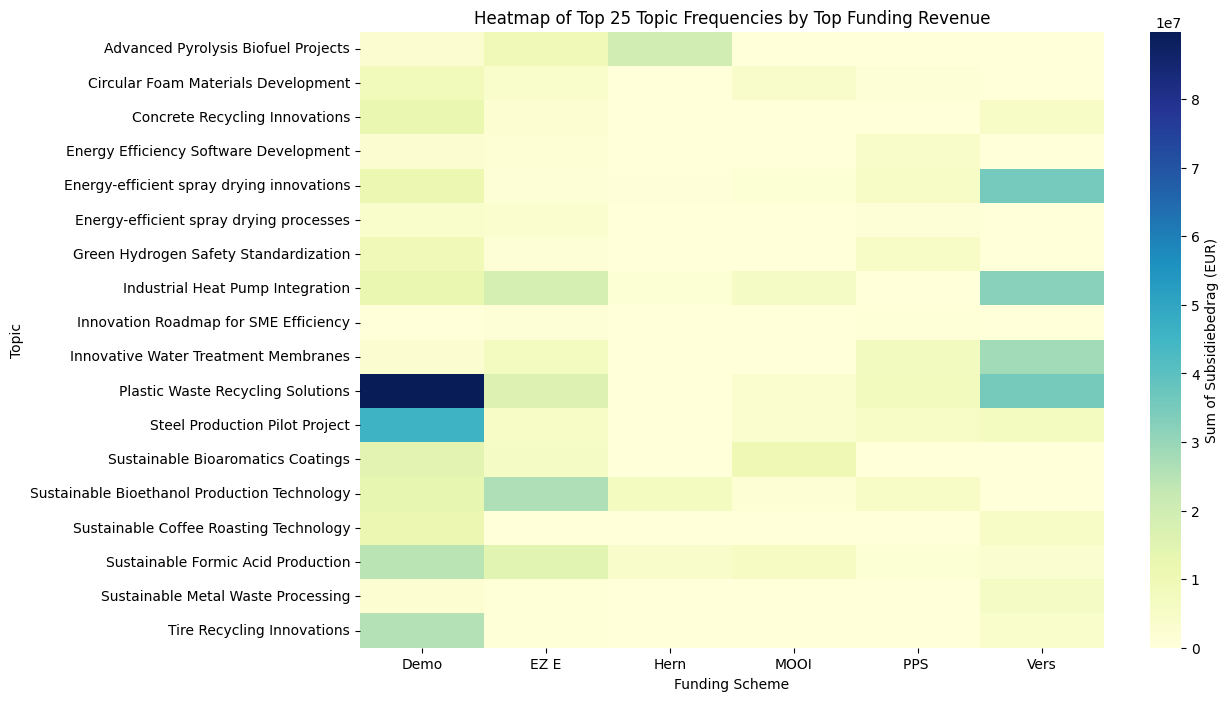

In [147]:
# Remove topics with CustomName 'Outlier Topic'
df_cleaned_projects = df_projects[df_projects['CustomName'] != 'Outlier Topic']

# Truncate funding scheme names
df_cleaned_projects['funding_scheme_truncated'] = df_cleaned_projects[COLUMN_FUNDING_SCHEME].str.slice(0, MAX_CHARACTERS)

# Find the top funding schemes
top_funding_schemes = df_cleaned_projects['funding_scheme_truncated'].value_counts().head(TOP_N_FUNDINGSCHEMES).index.tolist()

# Filter DataFrame to only include top funding schemes
df_top_funding_schemes = df_cleaned_projects[df_cleaned_projects['funding_scheme_truncated'].isin(top_funding_schemes)]

# Find the top 25 topics by frequency
top_25_topics = df_top_funding_schemes['CustomName'].value_counts().head(25).index.tolist()

# Filter DataFrame to only include top 25 topics
df_top_topics = df_top_funding_schemes[df_top_funding_schemes['CustomName'].isin(top_25_topics)]

# Create a pivot table to sum 'Subsidiebedrag' for each topic per funding scheme
heatmap_data = pd.pivot_table(df_top_topics, values='Subsidiebedrag', index='CustomName', columns='funding_scheme_truncated', aggfunc='sum', fill_value=0)

# Plot heatmap without annotations
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Sum of Subsidiebedrag (EUR)'})
plt.title("Heatmap of Topic Frequencies by Top Funding Revenue")
plt.xlabel("Funding Scheme")
plt.ylabel("Topic")
plt.show()

## **DEEP DIVE INTO TOPIC** <a class="anchor" id="deep_dive"></a>

In [148]:
DEEP_DIVE = False # set to True if you want to run a topic analysis on a specific topic again, by default it is off. Run cell below if set to True.
TOPICS_ZOOM = TOPICS[:1] # choose topic number, by default it is best match

In [149]:
if DEEP_DIVE is True:
    
    df_projects_zoom = df_projects[df_projects['Topic'].isin(TOPICS_ZOOM)]
    print(f'Data shape: {df_projects_zoom.shape}')
    display(df_projects_zoom.head(1))

    docs_zoom = list(df_projects_zoom.text.values) # create stacked list of abstracts
    embeddings_zoom = sentence_model.encode(docs_zoom, show_progress_bar=True)

    topic_model_zoom = BERTopic(verbose=True, 
                        calculate_probabilities=True,
                        top_n_words=8,
                        n_gram_range=(1, 2),
                        min_topic_size=4,
                        vectorizer_model=vectorizer_model,
                        representation_model=representation_model,
                        embedding_model=sentence_model)

    topics_zoom, probs_zoom = topic_model_zoom.fit_transform(docs_zoom, embeddings_zoom)
    
    if USE_OPENAI_REPERESENTATIONS is True:
        # add chatgpt labels to the model
        chatgpt_topic_labels_zoom = {topics_zoom: " | ".join(list(zip(*values))[0]) for topics_zoom, values in topic_model_zoom.topic_aspects_["OpenAI"].items()}
        chatgpt_topic_labels_zoom[-1] = "Outlier Topic"
        topic_model_zoom.set_topic_labels(chatgpt_topic_labels_zoom)

    display(topic_model_zoom.get_topic_info().head(2))
    display(topic_model_zoom.visualize_barchart(top_n_topics=8, n_words=10, custom_labels=True, width=400))

## **SOURCES** <a class="anchor" id="sources"></a>
- BERTOPIC EXAMPLE: https://towardsdatascience.com/topics-per-class-using-bertopic-252314f2640 <br>
- GENERAL INFO BERTOPIC: https://maartengr.github.io/BERTopic/getting_started/parameter%20tuning/parametertuning.html <br>
- OPENAI INTEGRATION: https://colab.research.google.com/drive/1BoQ_vakEVtojsd2x_U6-_x52OOuqruj2?usp=sharing#scrollTo=q9kRc7MD-XMD